In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
%matplotlib inline

In [2]:
path = './'
teamname = 'team_foo'
out_name = path + teamname + '_submission.csv'
df_usage = pd.read_csv(path + "train_usage_data.csv")

In [3]:
df_usage.head()

,id,feature_name,usage_duration,end_use_date,accepted
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False


In [4]:
df_usage.isnull().any()

id                False
feature_name      False
usage_duration    False
end_use_date      False
accepted          False
dtype: bool

In [5]:
df_users = pd.read_csv(path + "train_users_data.csv",parse_dates = [ 'installation_date','subscripiton_date'], index_col=0)
joined_df = df_usage.join(df_users.set_index('id'),on='id')
joined_df.head()

,id,feature_name,usage_duration,end_use_date,accepted,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False,2017-07-21 20:04:15,2018-04-05 22:39:32,United Kingdom,1.9.6,11.2.5,UIDeviceKindIPhoneX,NaN,0
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False,2018-04-21 02:01:23,2018-04-21 02:14:14,United States,1.9.6,11.2,UIDeviceKindIPhone8,NaN,0
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False,2018-04-30 12:45:44,2018-04-30 12:57:44,Australia,1.9.6,11.2.5,UIDeviceKindIPhone7Plus,NaN,0
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False,2018-04-29 21:14:23,2018-04-29 22:07:56,United States,1.9.6,11.2.6,UIDeviceKindIPhone6Plus,31.0,0


In [6]:
#usage duration by chruned
print(joined_df.groupby('churned')['usage_duration'].mean())
print(joined_df.groupby('churned')['usage_duration'].std())

churned
0    56.191571
1    58.626024
Name: usage_duration, dtype: float64
churned
0    593.080063
1    463.218981
Name: usage_duration, dtype: float64


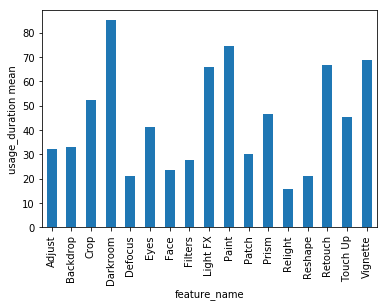

In [7]:
joined_df.groupby('feature_name')['usage_duration'].mean().plot.bar()
plt.ylabel('usage_duration mean')

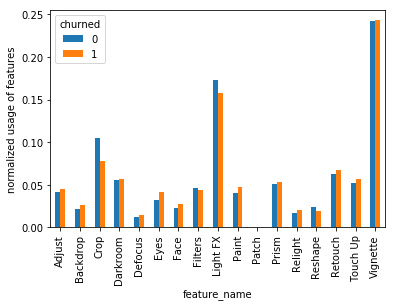

In [8]:
joined_df.groupby('churned')['feature_name'].value_counts(normalize =True).unstack(0).plot.bar()
plt.ylabel("normalized usage of features")

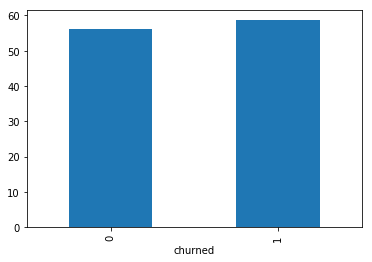

In [9]:
joined_df.groupby('churned')['usage_duration'].mean().plot.bar()

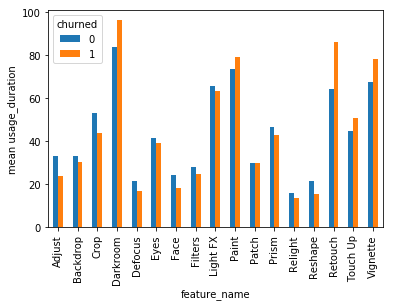

In [10]:
joined_df.groupby(['churned','feature_name'])['usage_duration'].mean().unstack(0).plot.bar()
plt.ylabel('mean usage_duration')

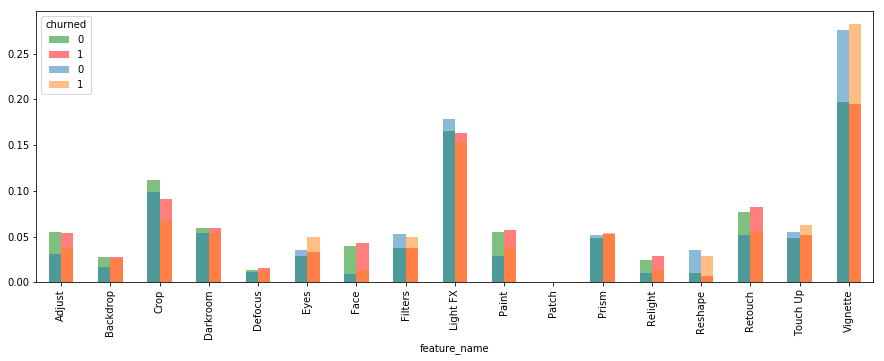

In [11]:
ax = joined_df[joined_df['accepted'] == 0].groupby(['churned'])['feature_name'].value_counts(normalize=True).unstack(0).plot.bar(alpha=0.5,figsize=(15,5), color=['g','r'])
joined_df[joined_df['accepted'] == 1].groupby(['churned'])['feature_name'].value_counts(normalize=True).unstack(0).plot.bar(ax=ax, alpha=0.5,figsize=(15,5))

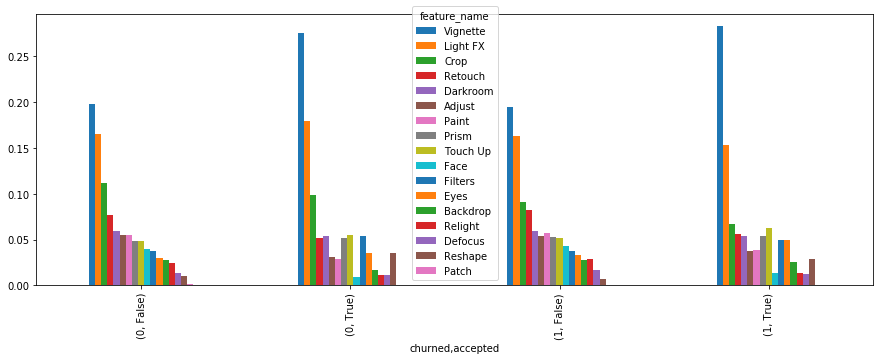

In [12]:
joined_df.groupby(['churned', 'accepted'])['feature_name'].value_counts(normalize=True).unstack([2]).plot.bar(figsize=(15,5))

## Here is te code for clustering the sessions
joined_df_with_cluster is the table with the session_id per session for each id.
note that for each id the counting is reset to 0.

In [13]:
import datetime
joined_df['end_use_date'] = pd.to_datetime(joined_df['end_use_date'])
joined_df['start_use_date'] = joined_df['end_use_date'] - joined_df['usage_duration'].apply(lambda x: datetime.timedelta(seconds=x))

In [14]:
def cluster(g):
    soted_g = g.sort_values(by='end_use_date')
    soted_g['delta'] = soted_g['start_use_date'].shift(-1) - soted_g['end_use_date']
    soted_g['delta'] = soted_g['delta'].apply(lambda x: x.total_seconds())
    soted_g['delta'] = soted_g['delta'].fillna(0)
    soted_g['class'] = 0
    soted_g.loc[soted_g['delta'] > 1000,'class'] = 1
    soted_g['class'] = soted_g['class'].cumsum()
    return pd.DataFrame(soted_g.index, soted_g['class'])
clustered_group = joined_df.groupby(['id']).apply(cluster)
clustered_group = clustered_group.reset_index()

In [15]:
clustered_group = clustered_group.set_index(0)

In [16]:
joined_df_with_cluster = clustered_group.merge(joined_df, left_index=True, right_index=True, how='inner')
joined_df_with_cluster.rename(index=str, columns={'id_x': 'id'}, inplace=True)
try:
    del joined_df_with_cluster['id_y']
except KeyError:
    pass

In [24]:
joined_df_with_cluster.to_csv('joined_df_with_cluster.csv')

### Feature: numver of session per user

In [18]:
num_of_sessions = joined_df_with_cluster.groupby('id_x')['class'].max()
num_of_sessions = pd.DataFrame(num_of_sessions)
num_of_sessions.reset_index(level=0, inplace=True)

In [25]:
num_of_sessions = num_of_sessions.rename(index=str, columns={'id_x': 'id', 'class': 'session_num'})
num_of_sessions.to_csv('number_sessions.csv', index=False)

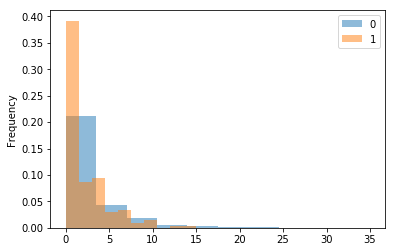

In [29]:
num_of_sessions.merge(df_users, left_on='id',right_on='id').groupby('churned')['session_num'].plot.hist(normed=True, alpha=0.5)
plt.legend()

### Feature: accepted rate per session

In [59]:
df = joined_df_with_cluster.groupby(['id_x', 'class'])['accepted'].value_counts(normalize=True).unstack(2)
df.reset_index(level=0, inplace=True)
df.fillna(0, inplace=True)
df = pd.DataFrame(df.groupby('id_x')[True].mean())
df.reset_index(level=0, inplace=True)
df = df.rename(index=str, columns={'id_x': 'id', True: 'accepted_rate_session'})
df.to_csv('accepted_rate_session.csv', index=False)

### Feature: duration mean per user

In [28]:
joined_df_with_cluster.head()

,id,class,feature_name,usage_duration,end_use_date,accepted,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned,start_use_date
123481,20000443246052,0,Vignette,399.849,2018-04-01 11:32:07,True,2017-11-29 11:16:40,2018-04-01 11:30:41,Brazil,1.9.5,11.2.6,UIDeviceKindIPhone6S,NaN,0,2018-04-01 11:25:27.151
100827,20000443246052,0,Crop,59.463,2018-04-01 11:33:10,False,2017-11-29 11:16:40,2018-04-01 11:30:41,Brazil,1.9.5,11.2.6,UIDeviceKindIPhone6S,NaN,0,2018-04-01 11:32:10.537
126858,20000443246052,0,Crop,6.961,2018-04-01 11:33:19,True,2017-11-29 11:16:40,2018-04-01 11:30:41,Brazil,1.9.5,11.2.6,UIDeviceKindIPhone6S,NaN,0,2018-04-01 11:33:12.039
111938,20000443246052,0,Retouch,73.048,2018-04-01 11:34:57,True,2017-11-29 11:16:40,2018-04-01 11:30:41,Brazil,1.9.5,11.2.6,UIDeviceKindIPhone6S,NaN,0,2018-04-01 11:33:43.952
122873,20000443246052,0,Prism,6.905,2018-04-01 11:35:09,False,2017-11-29 11:16:40,2018-04-01 11:30:41,Brazil,1.9.5,11.2.6,UIDeviceKindIPhone6S,NaN,0,2018-04-01 11:35:02.095


Index(['churned', 'usage_duration'], dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D7132AE48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000024D5C7E8B38>], dtype=object)

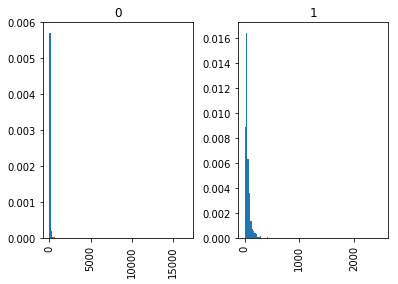

In [49]:
df = joined_df_with_cluster.groupby(['churned', 'id'])['usage_duration'].mean()
df = pd.DataFrame(df)
df.reset_index(level=0, inplace=True)
df.hist(column='usage_duration',by='churned', normed=True, bins=100)

In [53]:
df = joined_df_with_cluster.groupby(['id'])['usage_duration'].mean()
df = pd.DataFrame(df)
df.reset_index(level=0, inplace=True)
df.to_csv('usage_duration_mean.csv', index=True)

### Feature: hist of feature names and accepted rate

In [25]:
#Let's create a table with statistic summaries: rows correspond to users; columns to various statistics:
users_usage_summaries = pd.pivot_table(df_usage[['id', 'feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)

#Let's add the mean of 'accepted' for each user:
accepted_rate = df_usage.groupby(['id'])['accepted'].mean().to_frame()
churned = joined_df.groupby(['id'])['churned'].mean().to_frame()
users_usage_summaries = users_usage_summaries.join(accepted_rate, how='left').join(churned, how='left')
users_usage_summaries.reset_index(level=0, inplace=True)
users_usage_summaries.to_csv('feature_hist.csv', index=False)
users_usage_summaries.head()

,id,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,Patch,Prism,Relight,Reshape,Retouch,Touch Up,Vignette,accepted,churned
0,20000443246052,1,0,14,2,1,1,0,0,17,6,0,2,3,5,10,3,25,0.600000,0
1,20000443252617,2,2,0,7,0,0,0,0,16,1,0,10,2,0,4,3,14,0.409836,0
2,20000443310150,2,0,0,9,0,3,1,0,3,1,0,3,0,0,6,0,3,0.290323,0
3,20000443367561,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.000000,0
4,20000443405819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0.500000,0
